# Fine tuning with S-BERT

The models will be saved in this folder - https://drive.google.com/drive/folders/1ui5rywdrDdbBUeHph9AaA0VpfX01bbRe?usp=sharing


# Setup

In [ ]:
# Install necessary libraries
! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  wandb \
  onnx \
  onnxruntime \
  sentence_transformers==1.0.2 \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg

# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')

# Restarting the runtime is required for the libraries to be active in the notebook
import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 112kB 15.8MB/s 
     |████████████████████████████████| 12.8MB 19.1MB/s 
     |████████████████████████████████| 2.1MB 49.0MB/s 
     |████████████████████████████████| 12.2MB 45.4MB/s 
     |████████████████████████████████| 4.1MB 40.5MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 9.1MB 45.8MB/s 
     |████████████████████████████████| 460kB 52.0MB/s 
     |████████████████████████████████| 1.1MB 45.7MB/s 
     |████████████████████████████████| 163kB 56.4MB/s 
     |████████████████████████████████| 133kB 55.2MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 2.1MB 41.1MB/s 
     |████████████████████████████████| 1.2MB 47.6MB/s 
     |████████████████████████████████| 419kB 57.2MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 122kB 57.9MB

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6nm8m84m2L0mhy8MILXJPwp8lYDjrAL-UXPxp4dP6VfaSrkk60ebk


In [1]:
# Clone branch from github
!rm -rf policy-data-analyzer/
! branch_name='wandb-experiments' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 6102, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 6102 (delta 106), reused 79 (delta 52), pack-reused 5964
Receiving objects: 100% (6102/6102), 206.13 MiB | 27.86 MiB/s, done.
Resolving deltas: 100% (3351/3351), done.
Checking out files: 100% (1004/1004), done.


In [2]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
os.chdir("policy-data-analyzer") 

from tasks.fine_tuning_sbert.src.loops import *

Using the GPU


# Data Loading

In [3]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 16

Making new experiment folder for experiment # 16


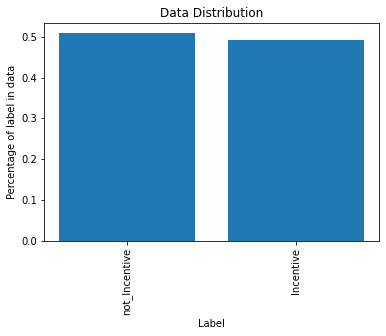

Label counts:
{'not_Incentive': 0.5081127241673783, 'Incentive': 0.4918872758326217}


In [5]:
experiment = "EXP26"
classifier = "Binary"

base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/{classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment # {GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)

make_dataset_public(train_sents, train_labels, label_names)

numeric_train_labels = labels2numeric(train_labels, label_names)

plot_data_distribution(numeric_train_labels, label_names)

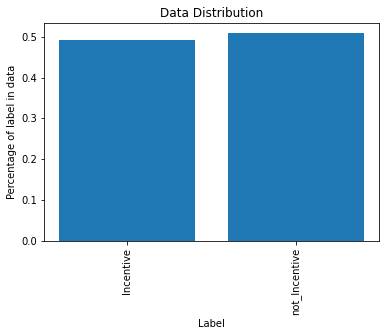

Label counts:
{'Incentive': 0.49146757679180886, 'not_Incentive': 0.5085324232081911}


In [6]:
# class balance/imbalance for test set
label_names_test = unique_labels(test_labels)
numeric_train_labels_test = labels2numeric(test_labels, label_names_test)

plot_data_distribution(numeric_train_labels_test, label_names_test)

In [7]:
# PASTE YOUR WEIGHTS & BIASES KEY HERE
wandb_key = '05b73a66f122fbefe48f986014ac18e169096014'
group_desc = 'test_bin_exp_26'
job_type = 'eval_results'

os.environ['WANDB_JOB_TYPE'] = job_type
os.environ['WANDB_RUN_GROUP'] = group_desc
os.environ['WANDB_API_KEY'] = wandb_key

## Grid Search Fine Tuning - W&B sweeps

In [ ]:
# wandb sweeps
sweep_config = {
    'method': 'random',
    "name": "SBERT hyperparam tuning"
}

metric = {
    'name': 'Weighted F1 validation',
    'goal': 'maximize'   
}

parameters_dict = {
    "dev_perc": {
        "values": [0.20, 0.25]
    },
    'model_name': {
        'values': ['paraphrase-xlm-r-multilingual-v1', 'stsb-xlm-r-multilingual', 'quora-distilbert-multilingual']
    },
    'seeds': {
        'values': [10, 11, 12]
    },
    # all values below are set but not varies
    "max_num_epochs": {
        "value": 10
    },
    "baseline": {
        "value": 0.001
    },
    "patience": {
        "value": 5
    },
    "eval_classifier": {
        "value": "SBERT"
    },
    "output_path": {
        "value": results_save_path
    }
}

sweep_config['parameters'] = parameters_dict
sweep_config['metric'] = metric

import pprint

pprint.pprint(sweep_config)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="WRI", entity="ramanshsharma")

In [ ]:
wandb.agent(sweep_id, train, count=5)

## Running training function for only one run

In [8]:
grid_search_params = {
    "all_dev_perc": 0.25,
    "model_names": 'paraphrase-xlm-r-multilingual-v1',
    #'stsb-xlm-r-multilingual', 'quora-distilbert-multilingual']
    "output_path": results_save_path,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "seeds": 10,
    "eval_classifier": "SBERT"
}

grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, label_names)

Grid Search Fine tuning parameters:
{
    "all_dev_perc": 0.25,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/Model_reproducibility/Model_results/BinaryClassificationExperiments/16",
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "seeds": 10,
    "eval_classifier": "SBERT"
}


wandb: Currently logged in as: thefirebanks (use `wandb login --relogin` to force relogin)


Evaluating: 100%|██████████| 37/37 [00:01<00:00, 31.52it/s]


Current Score is: 0.8498293515358362
Current ACC_LIST is: [1e-06, 0.8498293515358362]
Epoch: 0
Best score: 0.8498293515358362


Evaluating: 100%|██████████| 37/37 [00:01<00:00, 30.07it/s]


Current Score is: 0.8856655290102389
Current ACC_LIST is: [0.8498293515358362, 0.8856655290102389]
Epoch: 1
Best score: 0.8856655290102389


Evaluating: 100%|██████████| 37/37 [00:01<00:00, 31.13it/s]


Current Score is: 0.8907849829351536
Current ACC_LIST is: [0.8498293515358362, 0.8856655290102389, 0.8907849829351536]
Epoch: 2
Best score: 0.8907849829351536


Evaluating: 100%|██████████| 37/37 [00:01<00:00, 30.50it/s]


Current Score is: 0.8907849829351536
Current ACC_LIST is: [0.8498293515358362, 0.8856655290102389, 0.8907849829351536, 0.8907849829351536]
TRAINING EXITED. Best model has been found.
Epoch: 3
Best score: 0.8907849829351536


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


train_acc,0.98861
epoch,3
_runtime,101
_timestamp,1619414674
_step,19
validation_acc,0.89078
Macro F1 validation,0.89057
Weighted F1 validation,0.89065


train_acc,▁▅▇█
epoch,▁▁▁▁▃▃▃▃▆▆▆▆████
_runtime,▁▁▁▁▁▃▃▃▃▃▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▆▆▆▆▆█████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
validation_acc,▁▇██
Macro F1 validation,▁▇██
Weighted F1 validation,▁▇██


Time taken for fine-tuning: 00:02:25.33


## Loading saved model

In [9]:
saved_model = EarlyStoppingSentenceTransformer(model_name_or_path=results_save_path)
str(saved_model)

'EarlyStoppingSentenceTransformer(\n  (0): Transformer(\n    (auto_model): XLMRobertaModel(\n      (embeddings): RobertaEmbeddings(\n        (word_embeddings): Embedding(250002, 768, padding_idx=1)\n        (position_embeddings): Embedding(514, 768, padding_idx=1)\n        (token_type_embeddings): Embedding(1, 768)\n        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n        (dropout): Dropout(p=0.1, inplace=False)\n      )\n      (encoder): RobertaEncoder(\n        (layer): ModuleList(\n          (0): RobertaLayer(\n            (attention): RobertaAttention(\n              (self): RobertaSelfAttention(\n                (query): Linear(in_features=768, out_features=768, bias=True)\n                (key): Linear(in_features=768, out_features=768, bias=True)\n                (value): Linear(in_features=768, out_features=768, bias=True)\n                (dropout): Dropout(p=0.1, inplace=False)\n              )\n              (output): RobertaSelfOutput(\n          

In [10]:
torch.save(saved_model, 'statedict.pt')

In [11]:
newmodel = torch.load('statedict.pt')
newmodel.eval()
str(newmodel)

'EarlyStoppingSentenceTransformer(\n  (0): Transformer(\n    (auto_model): XLMRobertaModel(\n      (embeddings): RobertaEmbeddings(\n        (word_embeddings): Embedding(250002, 768, padding_idx=1)\n        (position_embeddings): Embedding(514, 768, padding_idx=1)\n        (token_type_embeddings): Embedding(1, 768)\n        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n        (dropout): Dropout(p=0.1, inplace=False)\n      )\n      (encoder): RobertaEncoder(\n        (layer): ModuleList(\n          (0): RobertaLayer(\n            (attention): RobertaAttention(\n              (self): RobertaSelfAttention(\n                (query): Linear(in_features=768, out_features=768, bias=True)\n                (key): Linear(in_features=768, out_features=768, bias=True)\n                (value): Linear(in_features=768, out_features=768, bias=True)\n                (dropout): Dropout(p=0.1, inplace=False)\n              )\n              (output): RobertaSelfOutput(\n          

## Testing model on test set

In [12]:
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluate_using_sbert(newmodel, test_sents, test_labels, label_names,
                         None, numeric_test_labels, output_path=results_save_path, testing=True)

Classifying sentences...


100%|██████████| 586/586 [00:00<00:00, 5886.33it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.78      0.35      0.48       288
not_Incentive       0.59      0.91      0.71       298

     accuracy                           0.63       586
    macro avg       0.69      0.63      0.60       586
 weighted avg       0.68      0.63      0.60       586

Visualizing...
Macro/Weighted Avg F1-score: [0.5975274725274725, 0.5995199339909238]


[0.5975274725274725, 0.5995199339909238]

## Trying to load a model with wandb

In [ ]:
run = wandb.init(project='WRI', entity='ramanshsharma')

artifact = run.use_artifact('ramanshsharma/WRI/model:v0', type='model')
artifact_dir = artifact.download()

run.join()

## Define evaluation classifier (optional)
If using a sklearn or other non-SBERT model as a classifier for evaluation, uncomment one of these models (or add your own and name it `clf`)

In [13]:
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [25]:
# clf = LGBMClassifier(n_estimators=2000,
#                       feature_fraction=0.06,
#                       bagging_fraction=0.67,
#                       bagging_freq=1,
#                       verbose=0,
#                       n_jobs=6,
#                       random_state=69420)

# clf = svm.SVC(gamma=0.001, C=100.)

clf = RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=69420)

In [27]:
evaluate_using_sklearn(clf, newmodel, train_sents, train_labels, test_sents, test_labels,
                           label_names, testing=True)

  0%|          | 8/2342 [00:00<00:32, 71.83it/s]

Classifying sentences...


100%|██████████| 586/586 [00:07<00:00, 75.26it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.87      0.89      0.88       288
not_Incentive       0.89      0.87      0.88       298

     accuracy                           0.88       586
    macro avg       0.88      0.88      0.88       586
 weighted avg       0.88      0.88      0.88       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8788307690515507, 0.8788484118358215]


[0.8788307690515507, 0.8788484118358215]